# To do:
    -Upscaling and Time Composite of Data
    -Creation of Full 3D Predictor Field
    -Basic Functionality
    -Basic Functionality for multiple patches (Patch extraction has to be random, but reproducible)
    -Efficiently save patch as (patch, lat, lon, features)
    -Store Relevant metadata for each patch
    -Variable patch/domain size
    -Add MESH Target
    -Add Cloud Top Temperature

# Import Statements

In [1]:
# Import packages 
import pandas as pd
import numpy as np
import netCDF4
import h5netcdf
import xarray as xr
from os.path import join
import joblib
from glob import glob
import datetime as dt
import sys

#Custom Packages
sys.path.append('/home/samuel.varga/python_packages/WoF_post') #WoF post package
sys.path.append('/home/samuel.varga/python_packages/wofs_ml_severe/')
sys.path.append('/home/samuel.varga/python_packages/MontePython/')
sys.path.append('/home/samuel.varga/projects/deep_learning/')

from wofs.post.utils import (
    save_dataset,
    load_multiple_nc_files,
)
#from main.dl_2to6_data_pipeline import get_files, load_dataset

#Plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shapely
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from wofs.plotting.wofs_colors import WoFSColors
from wofs_ml_severe.data_pipeline.storm_report_loader import StormReportLoader
%matplotlib inline

lookup_file: /home/samuel.varga/python_packages/WoF_post/wofs/data/psadilookup.dat


# Data Loading

In [2]:
date='20190523'
init_time='0300'

In [3]:
ml_config = { 'ENS_VARS':  ['uh_2to5_instant',
                            'uh_0to2_instant',
                            'wz_0to2_instant',
                            'comp_dz',
                            'ws_80',
                            'hailcast',
                            'w_up',
                            'okubo_weiss',
                    ],
             
              'ENV_VARS' : ['mid_level_lapse_rate', 
                            'low_level_lapse_rate', 
                           ],
             
              'SVR_VARS': ['shear_u_0to1', 
                        'shear_v_0to1', 
                        'shear_u_0to6', 
                        'shear_v_0to6',
                        'shear_u_3to6', 
                        'shear_v_3to6',
                        'srh_0to3',
                        'cape_ml', 
                        'cin_ml', 
                        'stp',
                        'scp',
                       ]
            }

In [5]:
data_path=f'/work/mflora/SummaryFiles/{date}/{init_time}'
X_env, X_strm, ncfile, ll_grid  = load_dataset(data_path, TIMESCALE='2to6')

# Plotting Preparation

In [6]:
from wofs.plotting.util import decompose_file_path
dz_levels=np.arange(20,76,5)
cape_levels=np.arange(250,3751,250)
comps = decompose_file_path(ncfile)
start_date=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])+dt.timedelta(minutes=int(comps['TIME_INDEX'])*5)) #Beginning of forecast window
end_date=(start_date+dt.timedelta(minutes=240)).strftime('%Y%m%d%H%M') #End of forecast window
start_time=start_date.strftime('%Y%m%d%H%M') 
init_date=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])).strftime('%Y%m%d%H%M')

In [7]:
def add_map_stuff(ax, states, shape_feature):
    ax.add_feature(states, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.LAKES, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.COASTLINE, linewidth=.1, facecolor='none', edgecolor="black")        
    ax.add_feature(shape_feature)
    
    
def set_extent(ax, projection , crs, lat, lons,):
    """ Set the Map extent based the WoFS domain """
    # Set the extent. 
    xs, ys, _ = projection.transform_points(
            crs,
            np.array([lons.min(), lons.max()]),
            np.array([lats.min(), lats.max()])).T
    _xlimits = xs.tolist()
    _ylimits = ys.tolist()

    # The limit is max(lower bound), min(upper bound). This will create 
    # a square plot and make sure there is no white spaces between the map
    # the bounding box created by matplotlib. This also allows us to set the
    # WoFS domain boundaries in cases where we aren't plotting WoFS data 
    # (e.g., storm reports, warning polygons, etc.) 
    lims = (max([_xlimits[0]]+[_ylimits[0]]),min([_xlimits[-1]]+[_ylimits[-1]]))
        
    ax.set_xlim(lims)
    ax.set_ylim(lims) 
    
    return ax #0000 is 0000 the next day

In [8]:
ds = xr.load_dataset(ncfile, decode_times=False)
lats = ds['xlat'][::1, ::1]
lons = ds['xlon'][::1, ::1]
base_grid=[lats,lons]

shape = (len(lons), len(lats))

central_longitude = ds.attrs['STAND_LON']
central_latitude = ds.attrs['CEN_LAT']

standard_parallels = (ds.attrs['TRUELAT1'], ds.attrs['TRUELAT2'])
projection=ccrs.LambertConformal(central_longitude=central_longitude,
                                 central_latitude=central_latitude,
                                 standard_parallels=standard_parallels)
crs = ccrs.PlateCarree()
data_path = '/home/monte.flora/python_packages/WoF_post/wofs/data/'
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces")

county_file = join(data_path,'COUNTIES', 'countyl010g.shp')
reader = shpreader.Reader(county_file)
shape_feature = ShapelyFeature(reader.geometries(),
                               crs, facecolor='none', linewidth=0.2, edgecolor='black', )

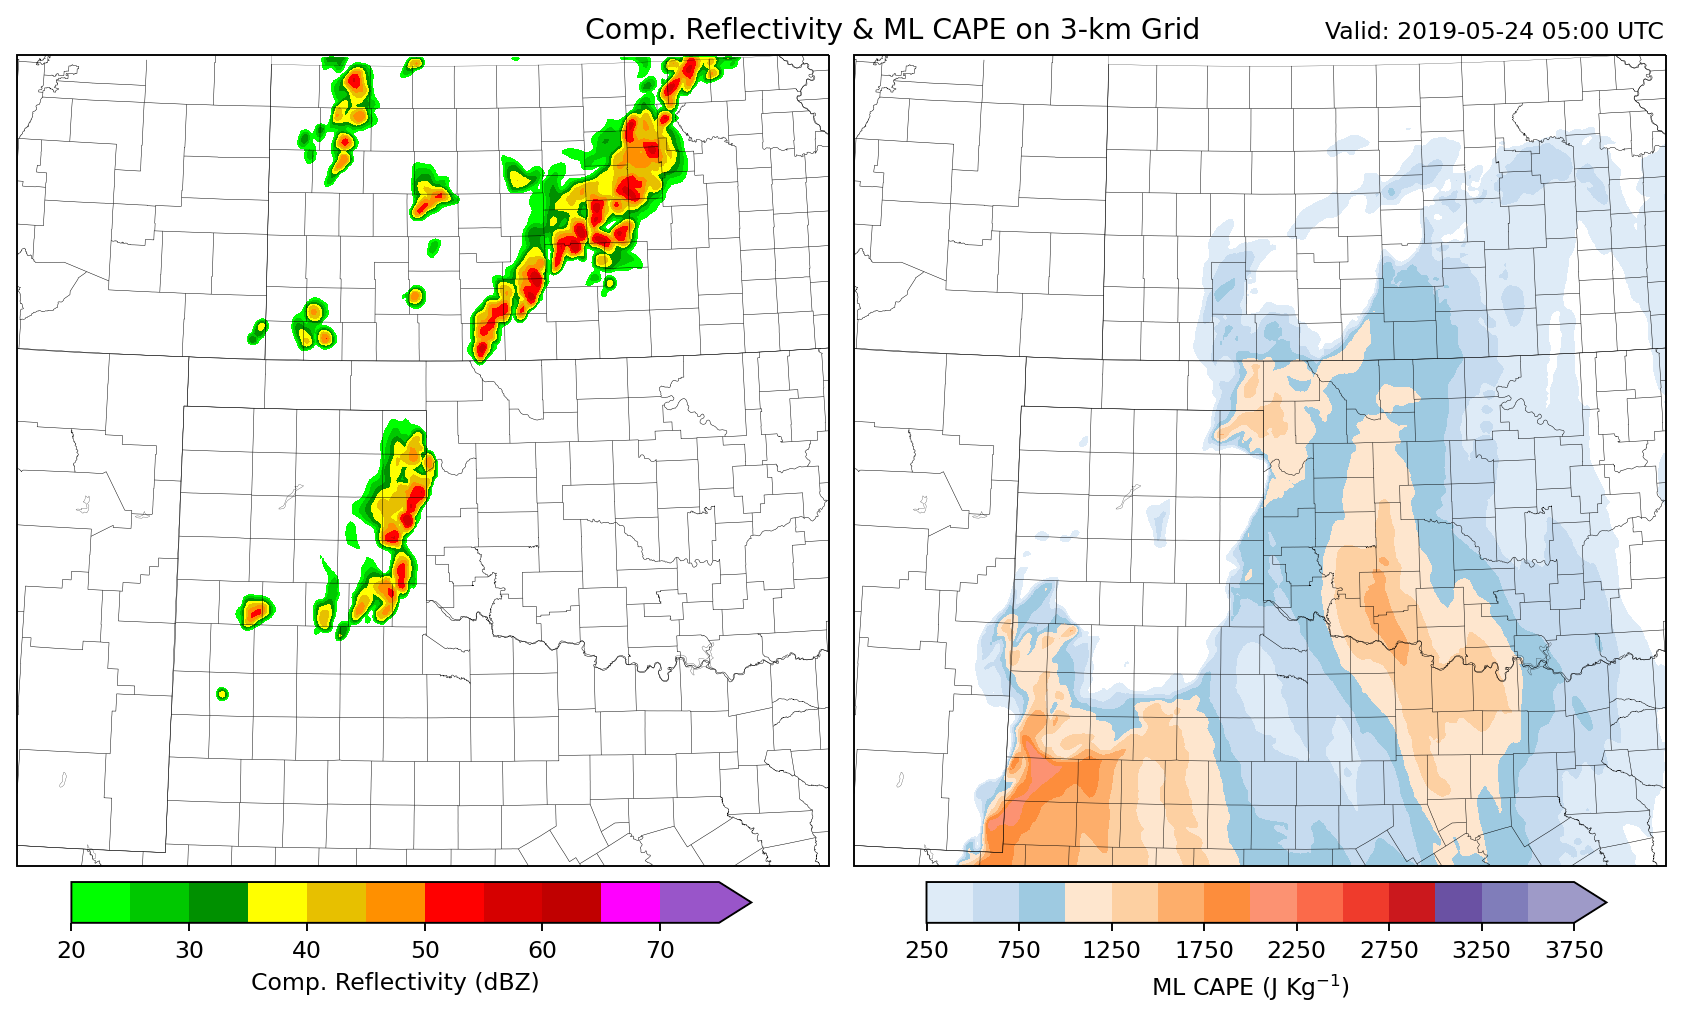

In [12]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=1, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)


levels= [dz_levels, cape_levels]
cmaps=[WoFSColors.nws_dz_cmap, WoFSColors.cape_cmap]
labels=['Comp. Reflectivity (dBZ)', 'ML CAPE (J Kg$^{-1}$)']
title='Comp. Reflectivity & ML CAPE on 3-km Grid'
X_s=[X_strm['comp_dz'][0][0],X_env['cape_ml'][0][0]]
conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[base_grid, base_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
  
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12
    #ax.set_title(f'{name}', fontsize=fontsize)

fig.tight_layout()

cax = [fig.add_axes([0.047, 0.16, 0.4, 0.03]),fig.add_axes([0.55, 0.16, 0.4, 0.03])]
axes[0].annotate(title, (0.7, 1.02), xycoords='axes fraction', fontsize=12, color='k') #(0.7, 1.02)
for cont, ax, label in zip(conts, cax, labels):
      fig.colorbar(cont, cax=ax,label=label, orientation='horizontal', extend='max')
        
#title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} - {end_date[8:10]}:{end_date[10:12]} UTC'        
time_title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} UTC'
axes[1].annotate(time_title, (0.58, 1.02), xycoords='axes fraction', fontsize=10, color='k')
plt.show()

# Patch Extractor

In [ ]:
class PatchExtractor:
    """
    Turns a forecast into a 2D predictor field, then returns multiple patches.
    Based heavily on the GridPointExtracter class.
    --------------------------------------------------------------------------
    The PE does the following:
    1) Replaces NaNs with field average and Upscales the Field
    2) Calculates the time composite of every ensemble member
    3) Calculates pointwise ens. statistics to produce predictors
    4) Creates multiple binary target fields from LSR/MRMS data
    5) Returns n patches of predictors and targets from the field
    --------------------------------------------------------------------------
    Class Methods:
    """
    
    def __init__(self, ncfile, env_vars, strm_vars, n_patches, patch_shape,
                forecast_window='2to6',
                target_sizes=[0.5, 1, 2, 4], 
                upscale_size=3, #Coarsens grid by 3x
                grid_spacing=3, #WoFS Grid Spacing (km)
                reports_path='/work/mflora/LSRS/StormEvents_2017-2022.csv',
                report_type='NOAA'
                ):
        
        #Set Object parameters
        self._upscale_size=3
        self_TARGET_SIZES=np.array(np.array(forecast_sizes)*2, dtype='int') #Convert from radius to diameter
        self._n_ens = 18 #Number of ens. members
        self._env_vars=env_vars
        self._strm_vars=strm_vars
        self._ncfile=ncfile
        self._DX = grid_spacing * self._upscale_size #Delta X of target grid
        self._reports_path = reports_path
        self._report_type = report_type
        self._forecast_window = forecast_window
        self._deltat = 5 #Time step of forecast in minutes
        self._original_grid = ll_grid
        self._target_grid = (self._original_grid[0][::self.upscale_size, ::self.upscale_size],
                             self._original_grid[1][::self.upscale_size, ::self._upscale_size])
        self._n_patches = n_patches #Number of patches to remove
        self._patch_shape = patch_shape #Patch shape in number of grid points (y, x)
        
        if np.max(np.absolute(ll_grid[0]))>90:
            raise ValueError('Latitude values for ll_grid exceed 90 and are likely longitude values.')
    
    def __call__(self, X_env, X_strm, predict=False):

In [ ]:
if n_patches*patch_area> NX*NY throw PatchError or no. valid patches < n_patches

In [ ]:
PatchExtractor()

# Upscale Data and Time Composite